In [59]:
import sys
import os

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Detected Kaggle Environment")
    
    
    dataset_path = "/kaggle/input/helper-files" 
    
    if os.path.exists(dataset_path):
        sys.path.append(dataset_path)
        print(f"✅ Added to path: {dataset_path}")
        sys.path.append("/kaggle/input/helper-files/Dataset")
    else:
        print(f"❌ Error: Could not find dataset at {dataset_path}. Check the folder name!")

else:
    print("Detected Local Environment")

    current_dir = os.getcwd()

    parent_dir = os.path.dirname(current_dir)

    sys.path.append(parent_dir)

Detected Local Environment


In [60]:
import yfinance as yf
import pandas as pd
from Data.Slider import Slider
from Data import Data_prep
from models.LSTM import LSTM
from torch import nn
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
from datetime import date

In [61]:

TICKER = 'Goldbees.ns'
START = '2009-01-02'
END = str(date.today())

data = yf.download(tickers = TICKER,
                   start = START,
                   end = END)
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOLDBEES.NS,GOLDBEES.NS,GOLDBEES.NS,GOLDBEES.NS,GOLDBEES.NS
Date,,,,,
2009-01-02,13.370000,13.430000,13.300000,0.000000,1043400
2009-01-05,13.155500,13.320000,13.150000,0.000000,1294700
2009-01-06,13.040000,13.200000,13.020100,0.000000,1236000
2009-01-07,13.215000,13.250000,13.060000,0.000000,1109000
2009-01-09,13.168900,13.200000,13.060000,0.000000,723900
...,...,...,...,...,...
2026-02-04,129.600006,132.000000,128.100006,128.250000,159221122
2026-02-05,125.220001,126.190002,121.610001,125.879997,128187910


In [62]:
df = pd.DataFrame(data)
df.set_index

<bound method DataFrame.set_index of Price            Close        High         Low        Open      Volume
Ticker     GOLDBEES.NS GOLDBEES.NS GOLDBEES.NS GOLDBEES.NS GOLDBEES.NS
Date                                                                  
2009-01-02   13.370000   13.430000   13.300000    0.000000     1043400
2009-01-05   13.155500   13.320000   13.150000    0.000000     1294700
2009-01-06   13.040000   13.200000   13.020100    0.000000     1236000
2009-01-07   13.215000   13.250000   13.060000    0.000000     1109000
2009-01-09   13.168900   13.200000   13.060000    0.000000      723900
...                ...         ...         ...         ...         ...
2026-02-04  129.600006  132.000000  128.100006  128.250000   159221122
2026-02-05  125.220001  126.190002  121.610001  125.879997   128187910
2026-02-06  125.040001  125.580002  121.550003  123.889999    95408028
2026-02-09  127.980003  129.899994  127.400002  129.100006    90368722
2026-02-10  128.339996  128.440002  127.

In [63]:
df.columns

MultiIndex([( 'Close', 'GOLDBEES.NS'),
            (  'High', 'GOLDBEES.NS'),
            (   'Low', 'GOLDBEES.NS'),
            (  'Open', 'GOLDBEES.NS'),
            ('Volume', 'GOLDBEES.NS')],
           names=['Price', 'Ticker'])

In [64]:
feat_cols = ['Open','High','Low','Volume']
feartures = df[feat_cols]
feartures = feartures.values

label_col = ['Close']
label = df[label_col]
label = label.values

In [65]:
train_size = int(len(feartures)*0.8)
X_train = feartures[:train_size]
X_test = feartures[train_size:]
Y_train = label[:train_size]
Y_test = label[train_size:]
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3372, 4) (3372, 1)
(844, 4) (844, 1)


In [66]:
from sklearn.preprocessing import MinMaxScaler

process_feat = MinMaxScaler(feature_range=(0,1))
process_targ = MinMaxScaler(feature_range=(0,1))

X_train = process_feat.fit_transform(X_train)
X_test = process_feat.fit_transform(X_test)

Y_train = process_targ.fit_transform(Y_train)
Y_test = process_targ.fit_transform(Y_test)

print(X_train[0],X_test[0],Y_train[0],Y_test[0])


[0.         0.25121376 0.26714483 0.00626884] [0.09867174 0.05098561 0.05497887 0.01109892] [0.26691172] [0.01285125]


In [67]:
slidertr = Slider(feature = X_train,
                labels = Y_train,
                length = 60)

sliderts = Slider(feature = X_test,
                labels = Y_test,
                length = 60)

x_trainf,y_trainf = slidertr.slider()
x_testf,y_testf = sliderts.slider()

In [68]:
#train data prep and load
x_t,y_t = Data_prep.convertNumpyToTensors(x_trainf,y_trainf)
train_dataset = Data_prep.createTensorDataset(x_t,y_t)
train_data_load = Data_prep.loadData(dataset=train_dataset,
                                               batch=32,
                                               num_worker=0)

In [69]:
#test data pred and load
x_te,y_te = Data_prep.convertNumpyToTensors(x_testf,y_testf)
test_dataset = Data_prep.createTensorDataset(x_te,y_te)
test_data_load = Data_prep.loadData(dataset=test_dataset,
                                               batch=32,
                                               num_worker=0,
                                               shuffle=False)

In [70]:
x,y = next(iter(train_data_load))
print(f'Shape of features {x.shape}')
print(f'Shape of target {y.shape}')

Shape of features torch.Size([32, 60, 4])
Shape of target torch.Size([32, 5, 1])


In [71]:
device = 'cuda' if(torch.cuda.is_available()) else 'cpu'

In [72]:
#model
INPUT_SIZE = 4
HIDDEN_UNITS = 64
OUT_FEATURES = 5
model = LSTM(in_size=INPUT_SIZE,
             hidden_units=HIDDEN_UNITS,
             out_features=OUT_FEATURES).to(device)

In [73]:
#loss funtiona and Optimizer
loss_fn = nn.MSELoss()
optimizer =torch.optim.Adam(params=model.parameters(),
                            lr = 1e-4)

In [74]:
#training and testing loop

def traintest(model:nn.Module,
          device:torch.device,
          Epoch:int,
          loss_fn:nn.MSELoss,
          optimizer:torch.optim.Adam,
          traindataloader:torch.utils.data.DataLoader,
          testdataloader: torch.utils.data.DataLoader,
          interval:int = 10):
    
  for epoch in range(Epoch):
    model.train()
    train_running_loss = 0.0
    test_running_loss = 0.0

    loop = iter(tqdm(traindataloader, desc = f'Epoch: {epoch+1}/{Epoch}'))

    for x,y in loop:
      x = x.to(device)  
      y = y.to(device)  
      train_pred = model(x)

      train_loss = loss_fn(train_pred,y.squeeze())
      train_running_loss += train_loss.item()

      optimizer.zero_grad()
      train_loss.backward()     
      optimizer.step()

    total_train_loss = train_running_loss/len(traindataloader)

    model.eval()
    with torch.inference_mode():
      
      for x,y in testdataloader:
        x = x.to(device)  
        y = y.to(device)  
        test_pred = model(x)

        test_loss = loss_fn(test_pred,y.squeeze())
        test_running_loss += test_loss.item()

      total_test_loss = test_running_loss/len(testdataloader)

    if epoch%interval == 0:
      print(f'|Train Loss: {total_train_loss : 0.4f} | Test Loss: {total_test_loss: 0.4f} |')
    

In [75]:
#training and testing
EPOCH=50
INTERVAL = 5
traintest(model=model,
          device=device,
          Epoch=EPOCH,
          loss_fn=loss_fn,
          optimizer=optimizer,
          traindataloader=train_data_load,
          testdataloader=test_data_load,
          interval=INTERVAL
          )

Epoch: 1/50: 100%|██████████| 104/104 [00:05<00:00, 20.09it/s]


|Train Loss:  0.2813 | Test Loss:  0.0555 |


Epoch: 6/50: 100%|██████████| 104/104 [00:05<00:00, 20.65it/s]


|Train Loss:  0.0007 | Test Loss:  0.0126 |


Epoch: 11/50: 100%|██████████| 104/104 [00:03<00:00, 30.33it/s]


|Train Loss:  0.0006 | Test Loss:  0.0124 |


Epoch: 16/50: 100%|██████████| 104/104 [00:02<00:00, 35.51it/s]


|Train Loss:  0.0006 | Test Loss:  0.0124 |


Epoch: 21/50: 100%|██████████| 104/104 [00:02<00:00, 42.63it/s]


|Train Loss:  0.0006 | Test Loss:  0.0117 |


Epoch: 26/50: 100%|██████████| 104/104 [00:01<00:00, 61.95it/s]


|Train Loss:  0.0006 | Test Loss:  0.0115 |


Epoch: 31/50: 100%|██████████| 104/104 [00:01<00:00, 53.99it/s]


|Train Loss:  0.0006 | Test Loss:  0.0113 |


Epoch: 36/50: 100%|██████████| 104/104 [00:02<00:00, 41.84it/s]


|Train Loss:  0.0006 | Test Loss:  0.0107 |


Epoch: 41/50: 100%|██████████| 104/104 [00:21<00:00,  4.87it/s]


|Train Loss:  0.0006 | Test Loss:  0.0102 |


Epoch: 46/50: 100%|██████████| 104/104 [00:09<00:00, 10.48it/s]


|Train Loss:  0.0006 | Test Loss:  0.0098 |


Epoch: 50/50: 100%|██████████| 104/104 [00:04<00:00, 22.31it/s]


Running inference on test data...


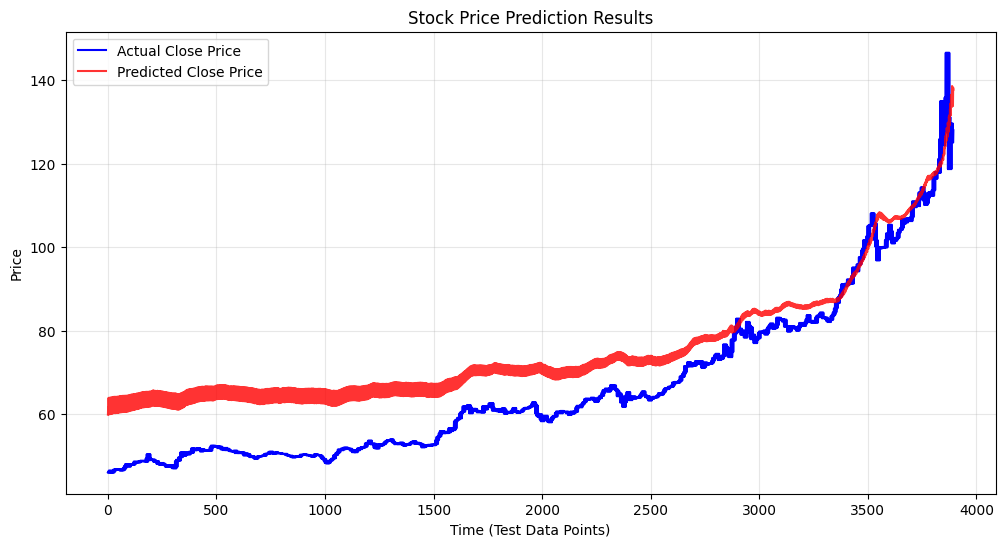

In [79]:
def plot_predictions(model:torch.nn,
                      test_loader: torch.utils.data.DataLoader, 
                      target_scaler):
    """
    Plots the model's predictions against actual values.
    Uses 'process_targ' to un-scale the data directly.
    """
   
    model.to('cpu')
    model.eval()
    
    # 1. Store Predictions and Actuals
    all_preds = []
    all_targets = []
    
    print("Running inference on test data...")
    
    with torch.no_grad():
        for x, y in test_loader:
            
            x = x.to("cpu")
            y = y.to("cpu") 
            
            
            output = model(x)
            
            
            all_preds.append(output.numpy())
            all_targets.append(y.numpy())
            
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    preds_flat = all_preds.reshape(-1, 1)
    targets_flat = all_targets.reshape(-1, 1)

    #unscaling
    real_preds = target_scaler.inverse_transform(preds_flat)
    real_targets = target_scaler.inverse_transform(targets_flat)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(real_targets, color='blue', label='Actual Close Price')
    plt.plot(real_preds, color='red', label='Predicted Close Price',  alpha=0.8)
    
    plt.title('Stock Price Prediction Results')
    plt.xlabel('Time (Test Data Points)')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


plot_predictions(model, test_data_load, process_targ)
#O on x axis refers to first day of testing and last day as the last of training 

In [ ]:
df[train_size:].shape

(842, 5)